In [2]:
# from decord import VideoReader, gpu
import torch
import clip
import cv2
from PIL import Image
import numpy as np
from tqdm import tqdm
from transformers import AutoProcessor, GroundingDinoForObjectDetection
from collections import defaultdict
import os
import json
import sys
sys.path.append('./')
import pandas as pd
import supg.datasource as datasource
from supg.sampler import ImportanceSampler
from supg.selector import ApproxQuery
from supg.selector import RecallSelector
from supg.selector import ImportancePrecisionTwoStageSelector
from supg.experiments.trial_runner import TrialRunner
import matplotlib.pyplot as plt

%matplotlib inline

In [120]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

In [3]:
def generate_proxy(video_uri, text_query):
    cap = cv2.VideoCapture(video_uri)
    text = clip.tokenize(text_query).to(device)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # frames = []
    results = []
    i = 0
    for _ in tqdm(range(total_frames), desc="Processing Frames", unit='frames'):
        ret, frame = cap.read()
        if not ret:
            break
        else:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = clip_preprocess(Image.fromarray(frame)).unsqueeze(0).to(device)
            with torch.no_grad():
                logits_per_image, logits_per_text = clip_model(frame, text)
                result = logits_per_image.cpu().numpy().tolist()
                results.append([i, result[0][0]])
                i += 1
    # for frame in tqdm(range(len(frames)), desc="Generating Proxy Scores", unit="frames"):
    # inputs = clip_preprocess(text=text_query, images=frames, return_tensors="pt", padding=True)
    # outputs = clip_model(**inputs)
    # logits_per_image = outputs.logits_per_image
    cap.release()
    return results

In [4]:
scores = generate_proxy('./hong_kong_airport_demo_data.mp4', 'black suitcase')

Processing Frames:  96%|█████████████████████████████████████████████████████▊  | 2701/2809 [00:53<00:02, 50.51frames/s]


In [5]:
def sample(scores, budget, mixing_eps=0.1):
    random = np.random.RandomState(0)
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    sorted_index = [score[0] for score in scores]
    proxy_scores = np.array([score[1] for score in scores])
    weights = np.sqrt(proxy_scores)
    weights = weights / np.sum(weights) * (1-mixing_eps) + 1/len(weights) * mixing_eps
    n = len(sorted_index)
    ranks = range(n)
    # Weighted Sampling
    if budget > n:
        budget = n
    if n != len(weights):
        weights = weights[:n]
        weights /= weights.sum()
    sampled_indexes = random.choice(n, size=budget, replace=True, p=weights)
    # sampled_weights = weights[sampled_indexes]
    return [sampled_indexes, weights]

In [6]:
sampled_indexes, weights = sample(scores, 100)
sampled_indexes = np.sort(sampled_indexes)

In [7]:
model_id = "IDEA-Research/grounding-dino-base"
gdino_processor = AutoProcessor.from_pretrained(model_id)
gdino_model = GroundingDinoForObjectDetection.from_pretrained(model_id).to(device)

/home/srijan/.conda/envs/dataset/lib/python3.12/site-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Could not load the custom kernel for multi-scale deformable attention: Error building extension 'MultiScaleDeformableAttention': [1/2] /usr/bin/nvcc --generate-dependencies-with-compile --dependency-output ms_deform_attn_cuda.cuda.o.d -DTORCH_EXTENSION_NAME=MultiScaleDeformableAttention -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -I/home/srijan/.conda/envs/dataset/lib/python3.12/site-packages/transformers/kernels/deformable_detr -isystem /home/srijan/.conda/envs/dataset/lib/python3.12/site-packages/torch/include -isystem /home/srijan/.conda/envs/dataset/lib/python3.12/site-packages/torch/include/torch/csrc/api/

In [13]:
def generate_oracle(sampled_indexes, video_uri, text_query):
    cap = cv2.VideoCapture(video_uri)
    results = []
    frames = []
    for index in tqdm(range(len(sampled_indexes)), desc="Processing Oracle", unit='frames'):
        cap.set(cv2.CAP_PROP_POS_FRAMES, index)
        ret, frame = cap.read()
        if not ret:
            break
        else:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame)
            inputs = gdino_processor(images=frame, text=text_query, return_tensors="pt").to(device)
            with torch.no_grad():
                outputs = gdino_model(**inputs)
            target_sizes = torch.tensor([frame.size[::-1]])
            result = gdino_processor.image_processor.post_process_object_detection(
                outputs,
                threshold=0.3,
                target_sizes=target_sizes
            )[0]
            results.append(result)
    cap.release()
    return results

In [14]:
oracle_results = generate_oracle(sampled_indexes, './hong_kong_airport_demo_data.mp4', 'black suitcase')

Processing Oracle: 100%|██████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.10frames/s]


In [59]:
oracle_results

[{'scores': tensor([], device='cuda:0'),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'boxes': tensor([], device='cuda:0', size=(0, 4))},
 {'scores': tensor([], device='cuda:0'),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'boxes': tensor([], device='cuda:0', size=(0, 4))},
 {'scores': tensor([], device='cuda:0'),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'boxes': tensor([], device='cuda:0', size=(0, 4))},
 {'scores': tensor([], device='cuda:0'),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'boxes': tensor([], device='cuda:0', size=(0, 4))},
 {'scores': tensor([], device='cuda:0'),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'boxes': tensor([], device='cuda:0', size=(0, 4))},
 {'scores': tensor([], device='cuda:0'),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'boxes': tensor([], device='cuda:0', size=(0, 4))},
 {'scores': tensor([], device='cuda:0'),
  'labels': tensor([], device

In [62]:
OBJECTS = ['monkey', 'bird', 'frisbee', 'person', 'sofa', 'cattle', 'horse', 'airplane', 'zebra', 'antelope', 
           'giant_panda', 'bear', 'car', 'hamster', 'bus', 'rabbit', 'domestic_cat', 'squirrel', 'turtle', 'tiger', 
           'snake', 'lion', 'ball', 'dog', 'watercraft', 'lizard', 'motorcycle', 'skateboard', 'train', 'bicycle', 
           'red_panda', 'elephant', 'fox', 'whale', 'sheep']

In [21]:
def read_json(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    return data

In [53]:
def get_ground_truth():
    json_files = [f for f in os.listdir('./test') if f.endswith('.json')]
    results = defaultdict(list)

    for file in tqdm(json_files, desc="Processing JSON files", unit="files"):
        data = read_json(f'./test/{file}')
        json_objects = { x['category']: x['tid'] for x in data['subject/objects'] }
        frames = data['trajectories']
        # print(json_objects)
        for obj in OBJECTS:
            for frame in frames:
                frame_tids = [x['tid'] for x in frame]
                if obj in json_objects and json_objects[obj] in frame_tids:
                    # print(f'{obj} present, with tid as {json_objects[obj]}')
                    results[obj].append(1)
                else:
                    results[obj].append(0)
    return dict(results)

In [54]:
ground_truth = get_ground_truth()

Processing JSON files: 100%|███████████████████████████████████████████████████████| 200/200 [00:02<00:00, 84.26files/s]


In [68]:
def generate_gdino_scores(video_uri, objects):
    cap = cv2.VideoCapture(video_uri)
    results = defaultdict(list)
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for obj in objects:
        text_query = f'a {obj}.'
        obj_res = []
        for _ in tqdm(range(num_frames), desc=f"Generating GroundingDINO scores for {obj}", unit='frames'):
            ret, frame = cap.read()
            if not ret:
                break
            else:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = Image.fromarray(frame)
                inputs = gdino_processor(images=frame, text=text_query, return_tensors="pt").to(device)
                with torch.no_grad():
                    outputs = gdino_model(**inputs)
                target_sizes = torch.tensor([frame.size[::-1]])
                frame_result = gdino_processor.image_processor.post_process_object_detection(
                    outputs,
                    threshold=0.5,
                    target_sizes=target_sizes
                )[0]
                scores = frame_result["scores"].cpu().tolist()
                if scores and len(scores) > 0:
                    obj_res.append(1)
                else:
                    obj_res.append(0)
        results[obj] = obj_res
    cap.release()
    return dict(results)

In [ ]:
gdino_labels = generate_gdino_scores('./out.mp4', ['dog'])

In [70]:
def generate_proxy(video_uri, objects):
    cap = cv2.VideoCapture(video_uri)
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # frames = []
    results = defaultdict(list)
    for obj in objects:
        text = clip.tokenize(f'a {obj}').to(device)
        obj_res = []
        for _ in tqdm(range(total_frames), desc=f"Processing Frames for {obj}", unit='frames'):
            ret, frame = cap.read()
            if not ret:
                break
            else:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = clip_preprocess(Image.fromarray(frame)).unsqueeze(0).to(device)
                with torch.no_grad():
                    logits_per_image, logits_per_text = clip_model(frame, text)
                    result = logits_per_image.cpu().numpy().tolist()
                    obj_res.append(result[0][0])
        results[obj] = obj_res
    cap.release()
    return dict(results)

In [125]:
proxy_scores = generate_proxy('./out.mp4', ['dog'])

Processing Frames for dog: 100%|██████████████████████████████████████████████| 49095/49095 [14:23<00:00, 56.85frames/s]


In [126]:
df_dog = pd.DataFrame({
    'id': range(len(proxy_scores['dog'])),
    'label': ground_truth.get('dog', []),
    'proxy_score': proxy_scores.get('dog', [])
})
df_dog['label'] = df_dog['label'].astype('float32')

In [127]:
df_dog

,id,label,proxy_score
0,0,1.0,25.781250
1,1,1.0,25.250000
2,2,1.0,24.921875
3,3,1.0,25.203125
4,4,1.0,24.375000
...,...,...,...
49090,49090,0.0,19.953125
49091,49091,0.0,19.468750
49092,49092,0.0,19.734375
49093,49093,0.0,19.546875


In [84]:
def run_helper(df, budget, target, qtype, delta=0.05, verbose=False):
    source = datasource.DFDataSource(df)
    sampler = ImportanceSampler()
    query = ApproxQuery(
            qtype=qtype,
            min_recall=target, min_precision=target, delta=0.05,
            budget=budget
    )

    if qtype == 'rt':
        selector = RecallSelector(query, source, sampler, sample_mode='sqrt', verbose=False)
    elif qtype == 'pt':
        selector = ImportancePrecisionTwoStageSelector(query, source, sampler)
    else:
        raise NotImplementedError

    trial_runner = TrialRunner()
    results_df = trial_runner.run_trials(
            selector=selector,
            query=query,
            sampler=sampler,
            source=source,
            nb_trials=100,
            verbose=verbose
    )
    return results_df

In [85]:
run_helper(df_dog, 10000, 0.9, 'rt', delta=0.05)

0.1405438435685915


,query_type,precision,recall,size,nb_true,nb_sampled,trial_idx,covered
0,rt,0.452107,0.940580,14355,6900,10000,0,True
1,rt,0.451815,0.941739,14382,6900,10000,1,True
2,rt,0.485790,0.928986,13195,6900,10000,2,True
3,rt,0.482071,0.931304,13330,6900,10000,3,True
4,rt,0.458735,0.937681,14104,6900,10000,4,True
...,...,...,...,...,...,...,...,...
95,rt,0.451817,0.940435,14362,6900,10000,95,True
96,rt,0.430217,0.947101,15190,6900,10000,96,True
97,rt,0.446857,0.942609,14555,6900,10000,97,True
98,rt,0.474259,0.931884,13558,6900,10000,98,True


In [90]:
run_helper(df_dog, 10000, 0.8, 'pt', delta=0.05)

0.1405438435685915


,query_type,precision,recall,size,nb_true,nb_sampled,trial_idx,covered
0,pt,1.000000,0.406812,2807,6900,10000,0,True
1,pt,1.000000,0.403043,2781,6900,10000,1,True
2,pt,0.991543,0.424783,2956,6900,10000,2,True
3,pt,1.000000,0.410725,2834,6900,10000,3,True
4,pt,1.000000,0.402319,2776,6900,10000,4,True
...,...,...,...,...,...,...,...,...
95,pt,1.000000,0.418551,2888,6900,10000,95,True
96,pt,1.000000,0.411014,2836,6900,10000,96,True
97,pt,1.000000,0.409130,2823,6900,10000,97,True
98,pt,1.000000,0.410435,2832,6900,10000,98,True


In [260]:
def run_supg(df, budget, target, qtype, delta=0.05, verbose=False):
    source = datasource.DFDataSource(df)
    sampler = ImportanceSampler()
    query = ApproxQuery(
            qtype=qtype,
            min_recall=target, min_precision=target, delta=delta,
            budget=budget
    )
    if qtype == 'rt':
        selector = RecallSelector(query, source, sampler, sample_mode='sqrt', verbose=False)
    elif qtype == 'pt':
        selector = ImportancePrecisionTwoStageSelector(query, source, sampler)
    else:
        raise NotImplementedError
    inds = selector.select()
    true_results = np.sum(source.lookup(inds))
    precision = true_results / len(inds)
    recall = true_results / np.sum(source.lookup(source.get_ordered_idxs()))
    f1 = 2 * (precision * recall) / (precision + recall)
    return {
        'frame_indexes': inds,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'selectivity': len(df[df['label'] == 1]) / len(df),
        'y_true': sum(df[df['label'] == 1]['label'])
    }

In [261]:
run_supg(df_dog, 10000, 0.95, 'pt')

0.1405438435685915


{'frame_indexes': array([    2,     4,     5, ..., 47228, 47231, 47234]),
 'precision': 1.0,
 'recall': 0.42492753,
 'f1_score': 0.5964198500337797,
 'selectivity': 0.1405438435685915,
 'y_true': 6900.0}

In [130]:
run_supg(df_dog, 10000, 0.95, 'rt')

0.1405438435685915


{'frame_indexes': array([    0,     1,     2, ..., 49083, 49084, 49094]),
 'precision': 0.2970979283537259,
 'recall': 0.9747826,
 'f1_score': 0.4553979460088278}

In [131]:
proxy_scores_frisbee = generate_proxy('./out.mp4', ['frisbee'])

Processing Frames for frisbee: 100%|██████████████████████████████████████████| 49095/49095 [14:20<00:00, 57.02frames/s]


In [132]:
df_frisbee = pd.DataFrame({
    'id': range(len(proxy_scores_frisbee['frisbee'])),
    'label': ground_truth.get('frisbee', []),
    'proxy_score': proxy_scores_frisbee.get('frisbee', [])
})
df_frisbee['label'] = df_frisbee['label'].astype('float32')

In [170]:
pt = run_supg(df_dog, 10000, 0.95, 'pt')
print(pt['frame_indexes'].shape)
print(run_supg(df_dog, 10000, 0.95, 'rt'))

0.1405438435685915
(2932,)
0.1405438435685915
{'frame_indexes': array([    0,     1,     2, ..., 49083, 49084, 49094]), 'precision': 0.2970979283537259, 'recall': 0.9747826, 'f1_score': 0.4553979460088278}


In [265]:
def plot_f1_target(df, subject):
    target_values = np.arange(0.7, 0.99, 0.05)
    f1_scores_rt = []
    f1_scores_pt = []
    precision_pt = []
    precision_rt = []
    recall_rt = []
    recall_pt = []
    for target in target_values:
        try:
            res_pt = run_supg(df, 10000, target, 'pt')
            res_rt = run_supg(df, 10000, target, 'rt')
            f1_scores_rt.append(res_rt['f1_score'])
            f1_scores_pt.append(res_pt['f1_score'])
            precision_pt.append(res_pt['precision'])
            precision_rt.append(res_pt['recall'])
            recall_rt.append(res_rt['recall'])
            recall_pt.append(res_rt['precision'])
        except:
            print(f'Error on target: {target}')
            f1_scores_pt.append(0)
            f1_scores_rt.append(0)
            
    fig, ax = plt.subplots(3, 1, figsize=(7, 7))
    ax[0].plot(target_values, precision_pt, label='precision_pt', color='blue', marker='o')
    ax[0].plot(target_values, recall_pt, label='recall_pt', color='red', marker='o')
    ax[0].set_title(f'precision query scores vs Target for {subject}')
    ax[0].set_ylabel('precision')
    # ax[0].legend()
    ax[1].plot(target_values, recall_rt, label='recall_rt', color='red', marker='o')
    ax[1].plot(target_values, precision_rt, label='precision_pt', color='blue', marker='o')
    ax[1].set_title(f'recall query scores vs Target for {subject}')
    ax[1].set_xlabel('Target')
    ax[1].set_ylabel('recall')
    # ax[1].legend()
    ax[2].plot(target_values, f1_scores_rt, label='rt', color='blue', marker='o')
    ax[2].plot(target_values, f1_scores_pt, label='pt', color='red', marker='o')
    ax[2].set_title(f'F1 Score vs Target for {subject}')
    ax[2].set_xlabel('Target')
    ax[2].set_ylabel('F1 Score')
    ax[2].legend()
    fig.tight_layout()
    plt.show()

0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915


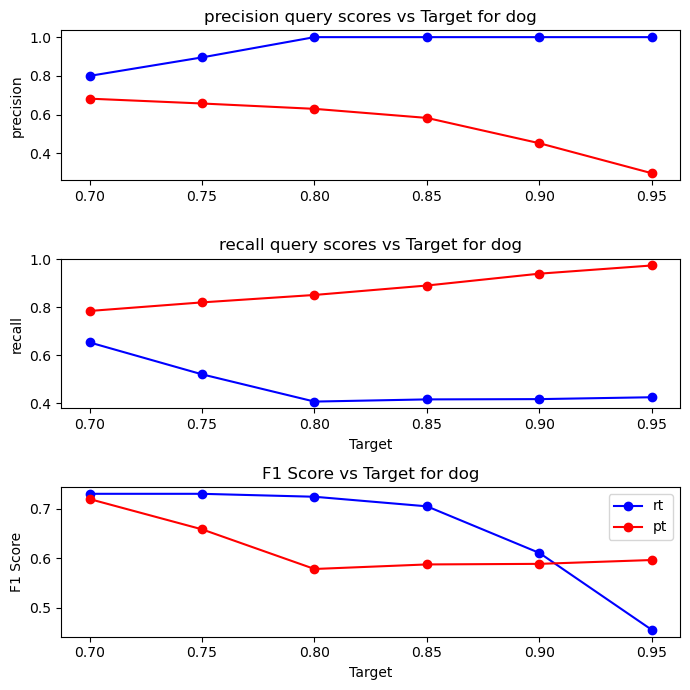

In [266]:
plot_f1_target(df_dog, 'dog')

0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467


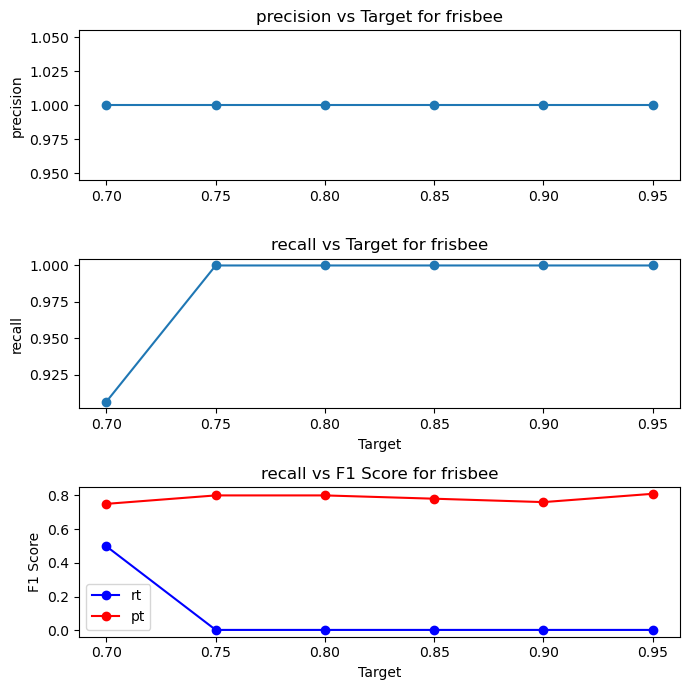

In [209]:
plot_f1_target(df_frisbee, 'frisbee')

In [148]:
proxy_scores_car = generate_proxy('./out.mp4', ['car'])


Processing Frames for car: 100%|██████████████████████████████████████████████| 49095/49095 [14:36<00:00, 55.99frames/s]


KeyError: 'dog'

In [149]:
df_car = pd.DataFrame({
    'id': range(len(proxy_scores_car['car'])),
    'label': ground_truth.get('car', []),
    'proxy_score': proxy_scores_car.get('car', [])
})
df_car['label'] = df_car['label'].astype('float32')
df_car

,id,label,proxy_score
0,0,0.0,20.078125
1,1,0.0,20.406250
2,2,0.0,20.000000
3,3,0.0,20.296875
4,4,0.0,19.437500
...,...,...,...
49090,49090,0.0,17.718750
49091,49091,0.0,17.109375
49092,49092,0.0,17.187500
49093,49093,0.0,17.812500


0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534


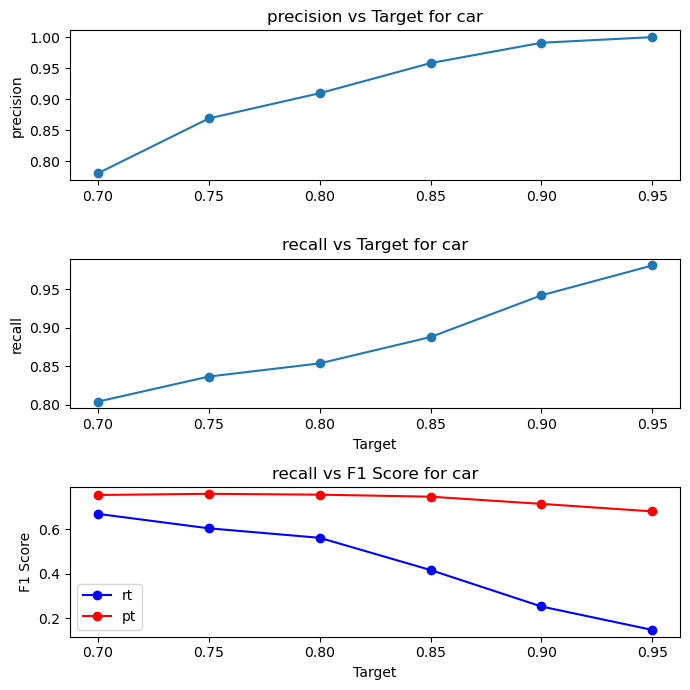

In [210]:
plot_f1_target(df_car, 'car')

In [160]:
proxy_scores_cat = generate_proxy('./out.mp4', ['domestic_cat'])
df_cat = pd.DataFrame({
    'id': range(len(proxy_scores_cat['domestic_cat'])),
    'label': ground_truth.get('domestic_cat', []),
    'proxy_score': proxy_scores_cat.get('domestic_cat', [])
})
df_cat['label'] = df_cat['label'].astype('float32')

Processing Frames for domestic_cat: 100%|█████████████████████████████████████| 49095/49095 [14:29<00:00, 56.43frames/s]


NameError: name 'df' is not defined

0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275


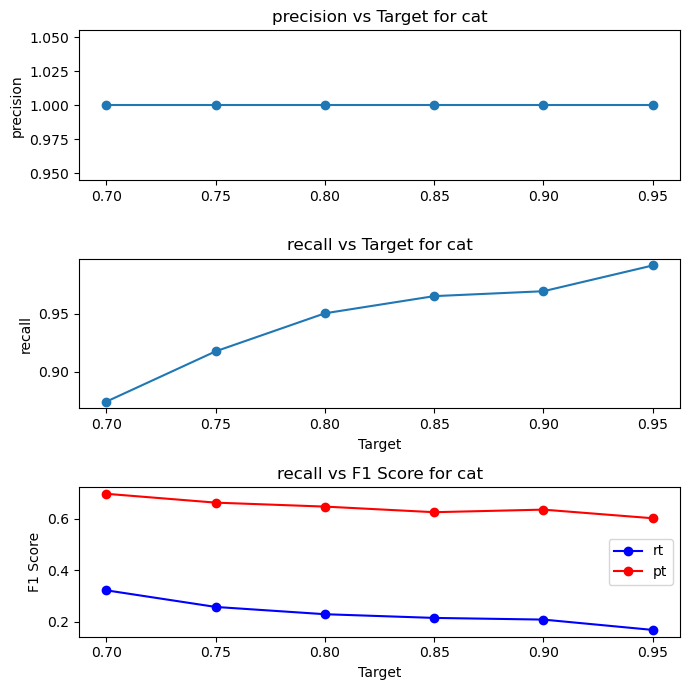

In [211]:
plot_f1_target(df_cat, 'cat')

In [175]:
def subject_selectivity():
    d = {}
    for key in ground_truth:
        d[key] = sum(ground_truth[key]) / len(ground_truth[key])
    return d

In [188]:
selectivity = subject_selectivity()
selectivity

{'monkey': 0.051023525817293004,
 'bird': 0.043996333638863426,
 'frisbee': 0.0015276504735716467,
 'person': 0.32325084020776046,
 'sofa': 0.0006110601894286587,
 'cattle': 0.02322028719828903,
 'horse': 0.07057745187901009,
 'airplane': 0.011304613504430187,
 'zebra': 0.060189428658722885,
 'antelope': 0.01466544454628781,
 'giant_panda': 0.04155209288114879,
 'bear': 0.011610143599144515,
 'car': 0.035747021081576534,
 'hamster': 0.007332722273143905,
 'bus': 0.0030553009471432934,
 'rabbit': 0.015276504735716468,
 'domestic_cat': 0.01924839596700275,
 'squirrel': 0.00458295142071494,
 'turtle': 0.009471432936144211,
 'tiger': 0.009471432936144211,
 'snake': 0.00977696303085854,
 'lion': 0.005499541704857928,
 'ball': 0.0018331805682859762,
 'dog': 0.1405438435685915,
 'watercraft': 0.036052551176290866,
 'lizard': 0.012526733883287504,
 'motorcycle': 0.01833180568285976,
 'skateboard': 0.007332722273143905,
 'train': 0.003360831041857623,
 'bicycle': 0.06782768102658111,
 'red_pand

In [187]:
sorted(selectivity, key=selectivity.get)

['sofa',
 'frisbee',
 'ball',
 'sheep',
 'bus',
 'train',
 'squirrel',
 'lion',
 'hamster',
 'skateboard',
 'whale',
 'turtle',
 'tiger',
 'snake',
 'airplane',
 'bear',
 'lizard',
 'antelope',
 'rabbit',
 'motorcycle',
 'domestic_cat',
 'cattle',
 'car',
 'watercraft',
 'giant_panda',
 'fox',
 'bird',
 'monkey',
 'zebra',
 'red_panda',
 'bicycle',
 'horse',
 'elephant',
 'dog',
 'person']

In [244]:
def plot_f1_budget(df, subject):
    budget_values = np.arange(100, 20000, 1000)
    f1_scores_rt = []
    f1_scores_pt = []
    precision = []
    recall = []
    for budget in budget_values:
        try:
            res_pt = run_supg(df, budget, 0.95, 'pt')
            res_rt = run_supg(df, budget, 0.95, 'rt')
            f1_scores_rt.append(res_rt['f1_score'])
            f1_scores_pt.append(res_pt['f1_score'])
            precision.append(res_pt['precision'])
            recall.append(res_rt['recall'])
        except:
            print(f'Error on budget: {budget}')
            precision.append(0)
            recall.append(0)
            f1_scores_pt.append(0)
            f1_scores_rt.append(0)
            
    fig, ax = plt.subplots(3, 1, figsize=(7, 7))
    ax[0].plot(budget_values, precision, label='pt', marker='o')
    ax[0].set_title(f'precision vs budget for {subject}')
    ax[0].set_ylabel('precision')
    # ax[0].legend()
    ax[1].plot(budget_values, recall, label='rt', marker='o')
    ax[1].set_title(f'recall vs budget for {subject}')
    ax[1].set_xlabel('Target')
    ax[1].set_ylabel('recall')
    # ax[1].legend()
    ax[2].plot(budget_values, f1_scores_rt, label='rt', color='blue', marker='o')
    ax[2].plot(budget_values, f1_scores_pt, label='pt', color='red', marker='o')
    ax[2].set_title(f'F1 Score vs budget for {subject}')
    ax[2].set_xlabel('Target')
    ax[2].set_ylabel('F1 Score')
    ax[2].legend()
    fig.tight_layout()
    plt.show()

0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915


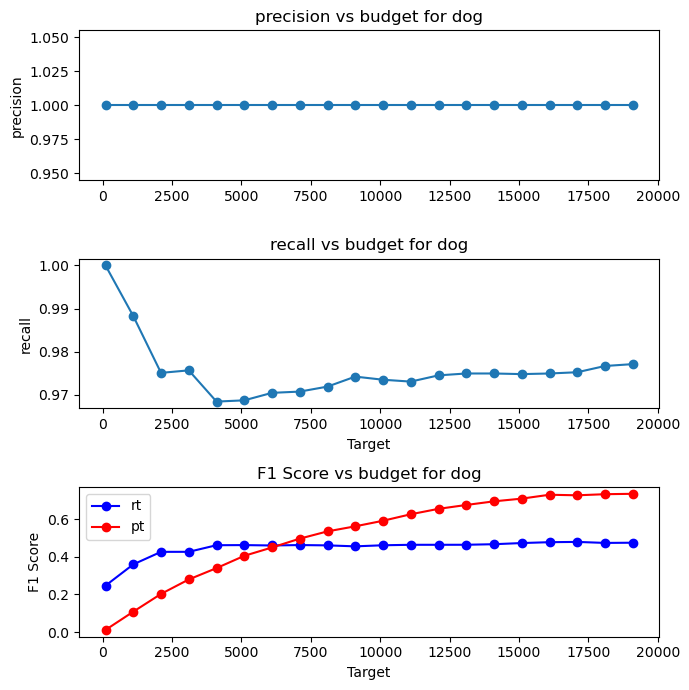

0.0015276504735716467


ValueError: probabilities do not sum to 1

In [245]:
plot_f1_budget(df_dog, 'dog')
plot_f1_budget(df_frisbee, 'frisbee')
plot_f1_budget(df_cat, 'cat')
plot_f1_budget(df_car, 'car')

In [231]:
def plot_f1_delta(df, subject):
    delta_values = np.arange(0.05, 0.35, 0.05)
    print(delta_values)
    f1_scores_rt = []
    f1_scores_pt = []
    precision = []
    recall = []
    for delta in delta_values:
        try:
            res_pt = run_supg(df, 10000, 0.95, 'pt', delta=delta)
            res_rt = run_supg(df, 10000, 0.95, 'rt', delta=delta)
            f1_scores_rt.append(res_rt['f1_score'])
            f1_scores_pt.append(res_pt['f1_score'])
            precision.append(res_pt['precision'])
            recall.append(res_rt['recall'])
        except:
            print(f'Error on target: {target}')
            f1_scores_pt.append(0)
            f1_scores_rt.append(0)
            
    fig, ax = plt.subplots(3, 1, figsize=(7, 7))
    ax[0].plot(delta_values, precision, label='pt', marker='o')
    ax[0].set_title(f'precision vs delta for {subject}')
    ax[0].set_ylabel('precision')
    # ax[0].legend()
    ax[1].plot(delta_values, recall, label='rt', marker='o')
    ax[1].set_title(f'recall vs delta for {subject}')
    ax[1].set_xlabel('Target')
    ax[1].set_ylabel('recall')
    # ax[1].legend()
    ax[2].plot(delta_values, f1_scores_rt, label='rt', color='blue', marker='o')
    ax[2].plot(delta_values, f1_scores_pt, label='pt', color='red', marker='o')
    ax[2].set_title(f'F1 Score vs delta for {subject}')
    ax[2].set_xlabel('Target')
    ax[2].set_ylabel('F1 Score')
    ax[2].legend()
    fig.tight_layout()
    plt.show()

[0.05 0.1  0.15 0.2  0.25 0.3 ]
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915


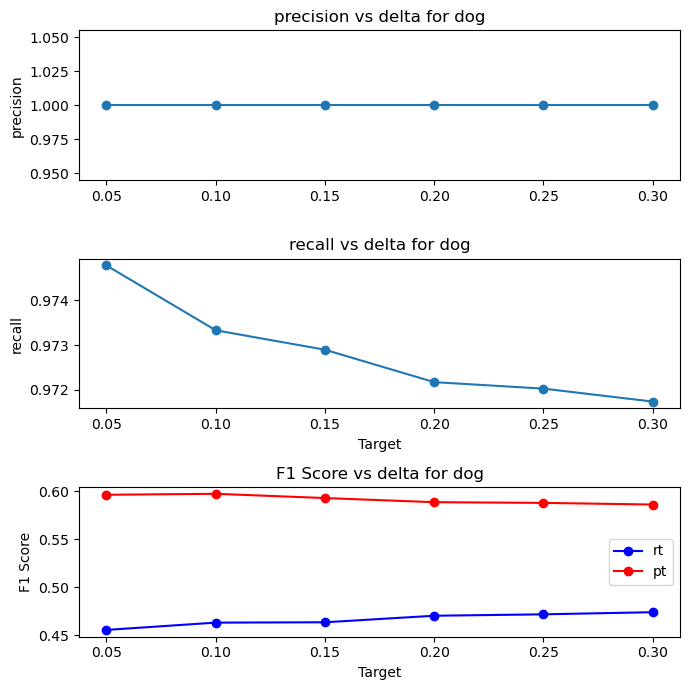

[0.05 0.1  0.15 0.2  0.25 0.3 ]
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467


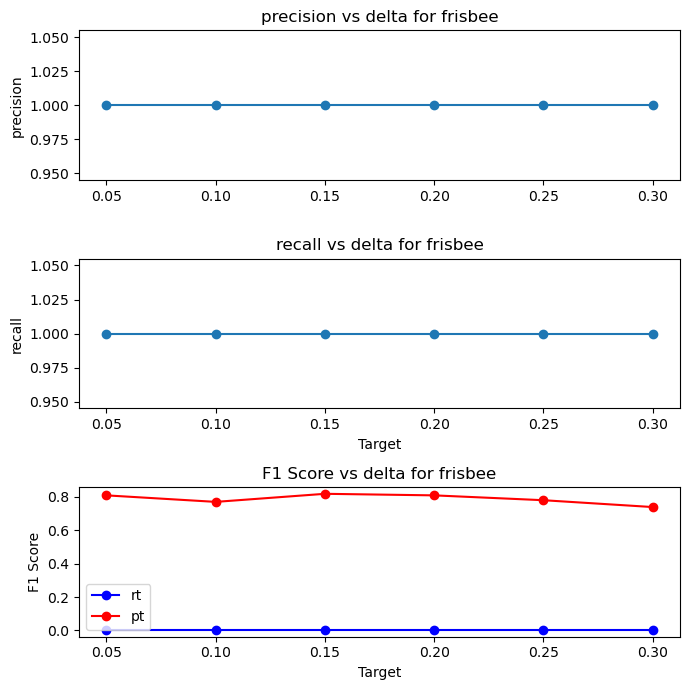

[0.05 0.1  0.15 0.2  0.25 0.3 ]
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275


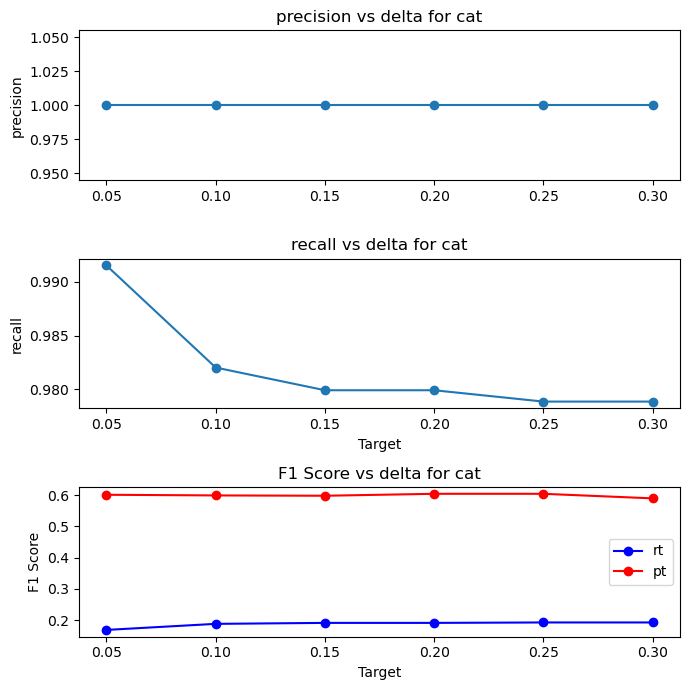

[0.05 0.1  0.15 0.2  0.25 0.3 ]
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534


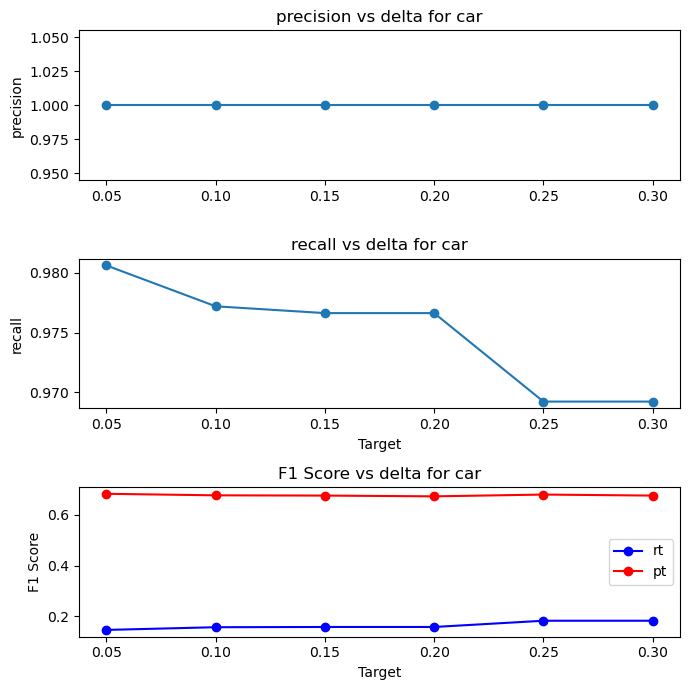

In [232]:
plot_f1_delta(df_dog, 'dog')
plot_f1_delta(df_frisbee, 'frisbee')
plot_f1_delta(df_cat, 'cat')
plot_f1_delta(df_car, 'car')

In [256]:
def plot_f1_budget(df, subject):
    budget_values = np.arange(1000, 20000, 1000)
    f1_scores_rt = []
    f1_scores_pt = []
    frames_rt = []
    frames_pt = []
    for budget in budget_values:
        try:
            res_pt = run_supg(df, budget, 0.95, 'pt')
            res_rt = run_supg(df, budget, 0.95, 'rt')
            f1_scores_rt.append(res_rt['f1_score'])
            f1_scores_pt.append(res_pt['f1_score'])
            frames_pt.append(res_pt['frame_indexes'].size)
            frames_rt.append(res_rt['frame_indexes'].size)
        except:
            print(f'Error on budget: {budget}')
            frames_rt.append(0)
            frames_pt.append(0)
            f1_scores_pt.append(0)
            f1_scores_rt.append(0)
            
    fig, ax = plt.subplots(3, 1, figsize=(7, 7))
    ax[0].plot(budget_values, frames_pt, label='pt', marker='o')
    ax[0].set_title(f'Num of Frames (PT) vs budget for {subject}')
    ax[0].set_ylabel('Num of Frames')
    # ax[0].legend()
    ax[1].plot(budget_values, frames_rt, label='rt', marker='o')
    ax[1].set_title(f'Num of Frames (RT) vs budget for {subject}')
    ax[1].set_xlabel('Target')
    ax[1].set_ylabel('Num of Frames')
    # ax[1].legend()
    ax[2].plot(budget_values, f1_scores_rt, label='rt', color='blue', marker='o')
    ax[2].plot(budget_values, f1_scores_pt, label='pt', color='red', marker='o')
    ax[2].set_title(f'F1 Score vs budget for {subject}')
    ax[2].set_xlabel('Target')
    ax[2].set_ylabel('F1 Score')
    ax[2].legend()
    fig.tight_layout()
    plt.show()

0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915
0.1405438435685915


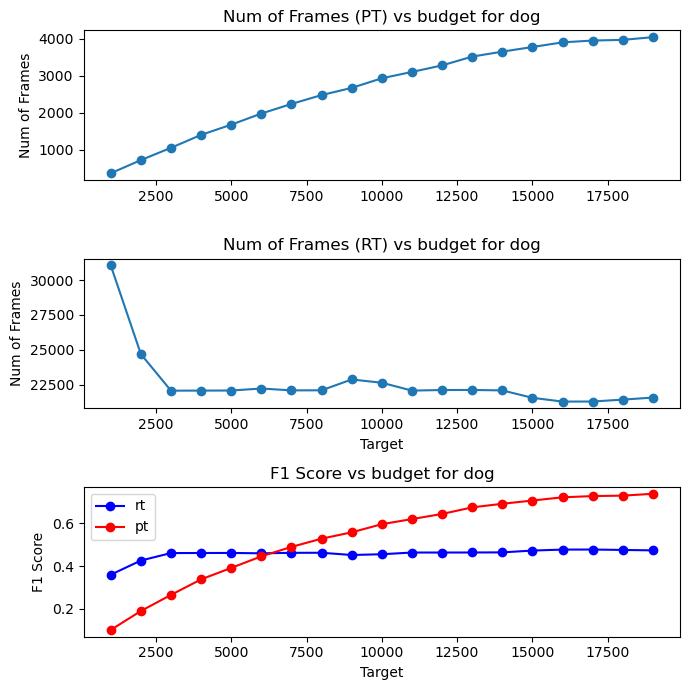

0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467
0.0015276504735716467


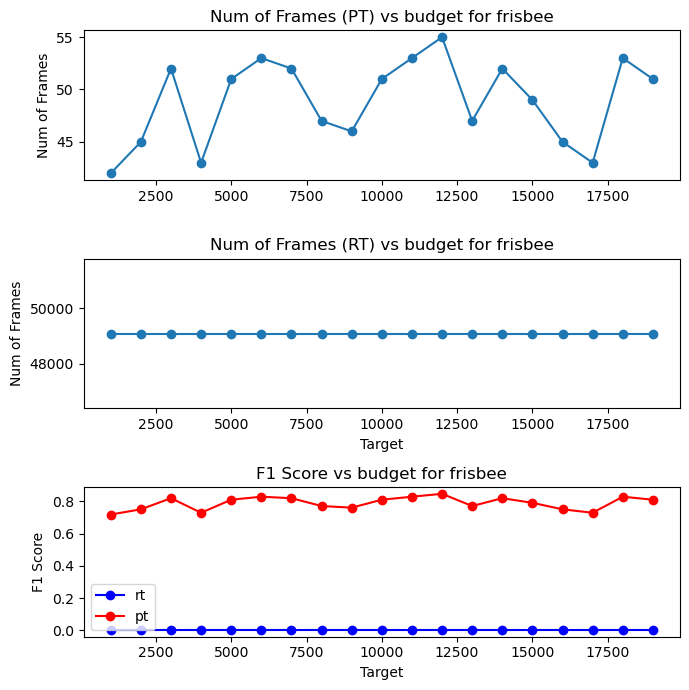

0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534
0.035747021081576534


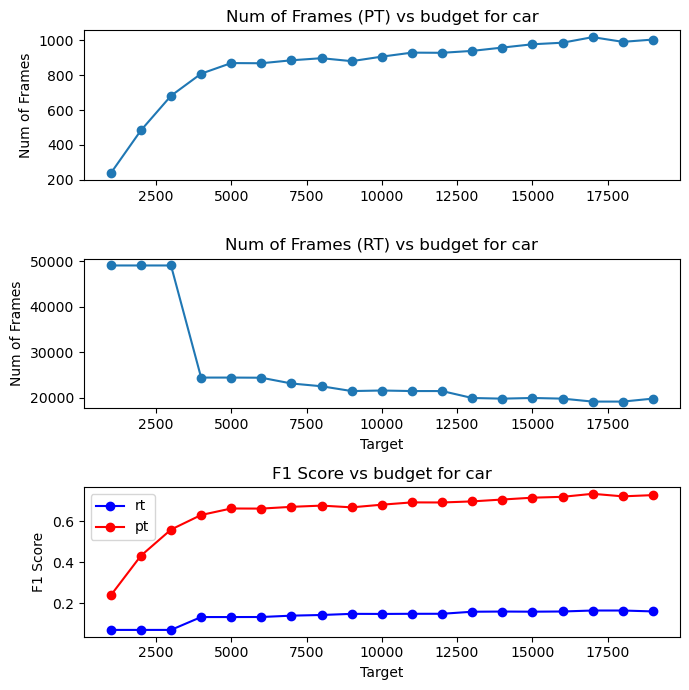

0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275
0.01924839596700275


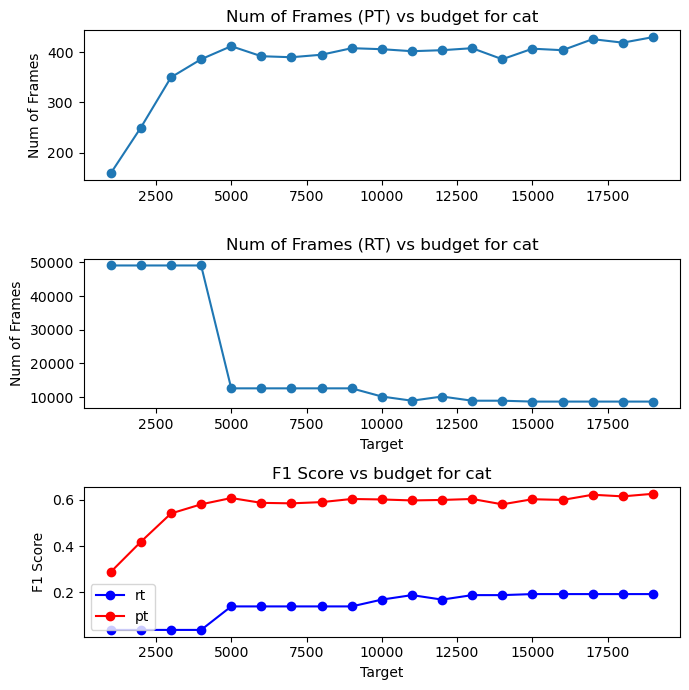

In [257]:
plot_f1_budget(df_dog, 'dog')
plot_f1_budget(df_frisbee, 'frisbee')
plot_f1_budget(df_car, 'car')
plot_f1_budget(df_cat, 'cat')

In [273]:
res = run_supg(df_dog, 100, 0.95, 'pt')
print(res['frame_indexes'].size)


0.1405438435685915
39


In [270]:
d = {
    'dog': [sum(df_dog[df_dog['label'] == 1]['label']), len(df_dog['label'])],
    'car': [sum(df_car[df_car['label'] == 1]['label']), len(df_car['label'])],
    'cat': [sum(df_cat[df_cat['label'] == 1]['label']), len(df_cat['label'])],
    'frisbee': [sum(df_frisbee[df_frisbee['label'] == 1]['label']), len(df_frisbee['label'])],
}
print(d)
# df_dog

{'dog': [6900.0, 49095], 'car': [1755.0, 49095], 'cat': [945.0, 49095], 'frisbee': [75.0, 49095]}


In [283]:
res = run_supg(df_dog, 10000, 0.95, 'rt')
print(res)

0.1405438435685915
{'frame_indexes': array([    0,     1,     2, ..., 49083, 49084, 49094]), 'precision': 0.2970979283537259, 'recall': 0.9747826, 'f1_score': 0.4553979460088278, 'selectivity': 0.1405438435685915, 'y_true': 6900.0}


In [291]:
csv_filename = 'dog.csv'
df_dog.to_csv(csv_filename, index=False)

In [292]:
csv_filename = 'car.csv'
df_car.to_csv(csv_filename, index=False)

In [293]:
csv_filename = 'frisbee.csv'
df_frisbee.to_csv(csv_filename, index=False)

In [294]:
csv_filename = 'cat.csv'
df_cat.to_csv(csv_filename, index=False)